# Data used by OGGM

In this notebook, we want to showcase what OGGM does best: **preparing data for your modelling workflow**.

We use preprocessed directories which contain most data available from [the OGGM shop](https://docs.oggm.org/en/stable/input-data.html) to illustrate how these could be used to inform data-based workflows.

## Preprocessed directories with additional products

We are going to use the South Glacier example taken from the [ITMIX experiment](https://www.the-cryosphere.net/11/949/2017/). It is a small (5.6 km2) glacier in Alaska.

In [1]:
## Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import salem

# OGGM
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = False
# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_Toy_Thickness_Model')
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(['RGI60-14.05446'], from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2023-03-14 09:04:36: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-14 09:04:36: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-14 09:04:36: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-03-14 09:04:37: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2023-03-14 09:04:37: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
100% of 168.8 MiB |######################| Elapsed Time: 0:00:58 Time:  0:00:58


In [3]:
# Pick our glacier
gdir = gdirs[0]
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-14.05446
  Region: 14: South Asia West
  Subregion: 14-02: Karakoram                       
  Name: Hassanabad Glacier I
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 45.712 km2
  Lon, Lat: (74.619, 36.4371)
  Grid (nx, ny): (134, 174)
  Grid (dx, dy): (105.0, -105.0)

## OGGM-Shop datasets

We are using the glacier directories processed especially to store more data than the default ones. In particular, they already store the data currently available in the OGGM shop:

In [4]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 134, y: 174)
Coordinates:
  * x                        (x) float32 -6.279e+03 -6.174e+03 ... 7.686e+03
  * y                        (y) float32 4.039e+06 4.039e+06 ... 4.021e+06
Data variables: (12/14)
    topo                     (y, x) float32 6.794e+03 6.829e+03 ... 3.782e+03
    topo_smoothed            (y, x) float32 6.74e+03 6.758e+03 ... 3.79e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    itslive_v                (y, x) float32 0.6974 1.081 1.712 ... 0.1377 0.1104
    millan_ice_thickness     (y, x) float32 8.761 24.3 30.38 ... nan nan nan
    millan_v                 (y, x) float32 0.4738 0.436 0.5834 ... 0.0 0.0 0.0
    millan_vx                (y, x) float32 -0.02371 0.3467 0.3173 ... nan nan
    millan_vy                (y, x) float32 0.4496 -0.1837 -0.3457 ... nan nan
    hugonnet_dhdt            (y, x) float32 nan 10.43 ... 0.007979 0.006662
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=74.619 +k=0.9996 +x_0=0 +y_0=...
    max_h_dem:      7539.0
    min_h_dem:      2409.0
    max_h_glacier:  7445.0
    min_h_glacier:  2476.0

That's already quite a lot! We have access to a bunch of data for this glacier, lets have a look. We prepare the map first:

In [5]:
import salem
import matplotlib.pyplot as plt
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

## Hugonnet dh/dt data

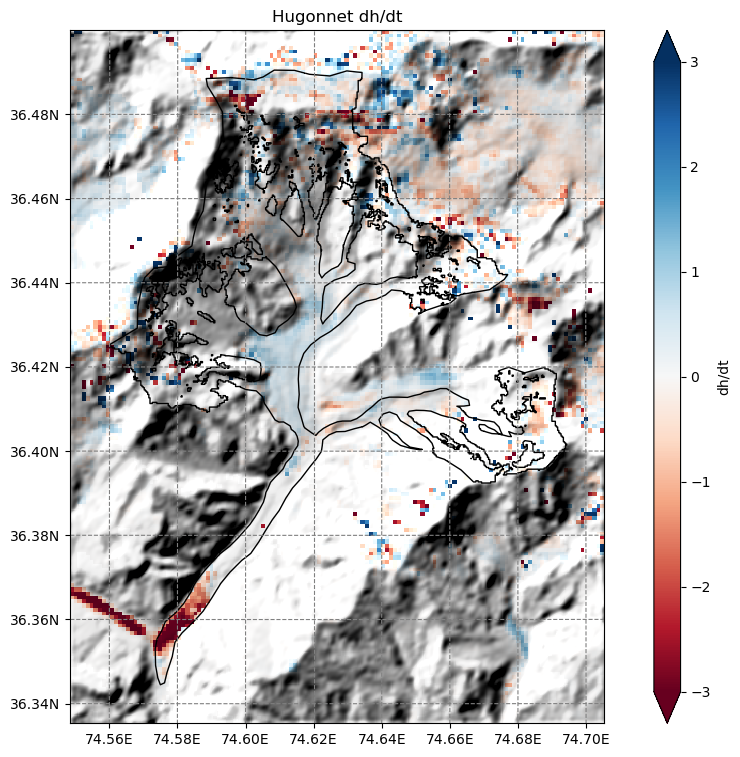

In [12]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

smap.set_data(ds.hugonnet_dhdt)
smap.set_cmap('RdBu')
smap.set_plot_params(vmin=-3, vmax=3)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='dh/dt')

ax.set_title('Hugonnet dh/dt');

## ITSLive velocity data 

In [13]:
# get the velocity data
u = ds.itslive_vx.where(ds.glacier_mask)
v = ds.itslive_vy.where(ds.glacier_mask)
ws = ds.itslive_v.where(ds.glacier_mask)

The `.where(ds.glacier_mask)` command will remove the data outside of the glacier outline.

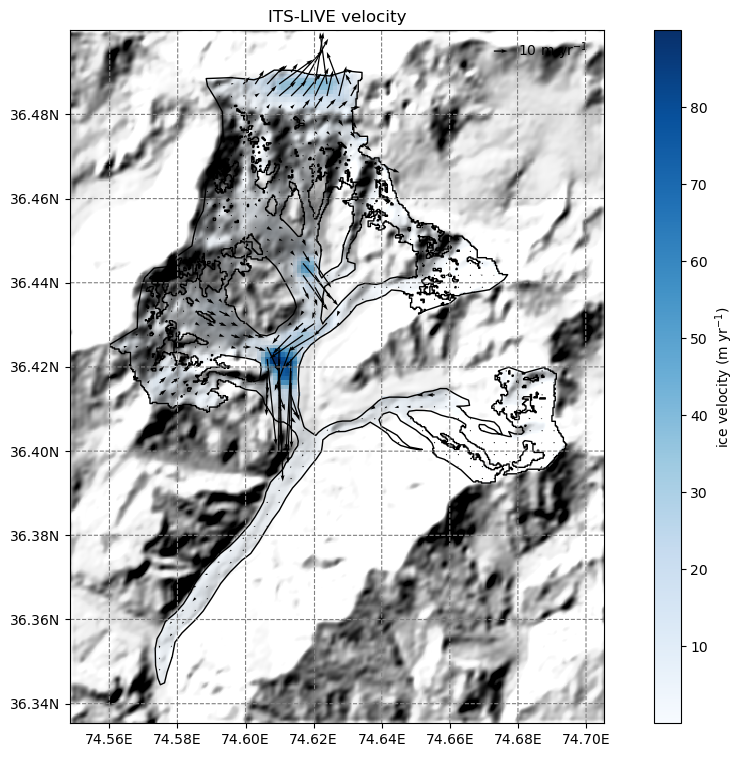

In [15]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

# Quiver only every N grid point
us = u[1::3, 1::3]
vs = v[1::3, 1::3]

smap.set_data(ws)
smap.set_cmap('Blues')
smap.set_plot_params()
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice velocity (m yr$^{-1}$)')

# transform their coordinates to the map reference system and plot the arrows
xx, yy = smap.grid.transform(us.x.values, us.y.values, crs=gdir.grid.proj)
xx, yy = np.meshgrid(xx, yy)
qu = ax.quiver(xx, yy, us.values, vs.values)
qk = ax.quiverkey(qu, 0.82, 0.97, 10, '10 m yr$^{-1}$',
                  labelpos='E', coordinates='axes')
ax.set_title('ITS-LIVE velocity');

## Millan 2022 velocity data 

In [16]:
# get the velocity data
u = ds.millan_vx.where(ds.glacier_mask)
v = ds.millan_vy.where(ds.glacier_mask)
ws = ds.millan_v.where(ds.glacier_mask)

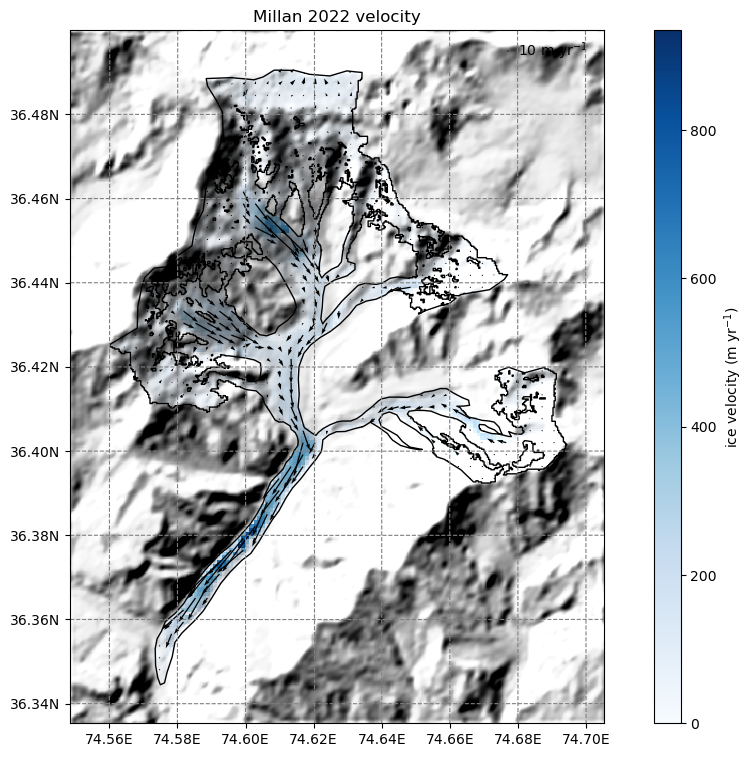

In [17]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

# Quiver only every N grid point
us = u[1::3, 1::3]
vs = v[1::3, 1::3]

smap.set_data(ws)
smap.set_cmap('Blues')
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice velocity (m yr$^{-1}$)')

# transform their coordinates to the map reference system and plot the arrows
xx, yy = smap.grid.transform(us.x.values, us.y.values, crs=gdir.grid.proj)
xx, yy = np.meshgrid(xx, yy)
qu = ax.quiver(xx, yy, us.values, vs.values)
qk = ax.quiverkey(qu, 0.82, 0.97, 10, '10 m yr$^{-1}$',
                  labelpos='E', coordinates='axes')
ax.set_title('Millan 2022 velocity');

## Thickness data from Farinotti 2019 and Millan 2022 

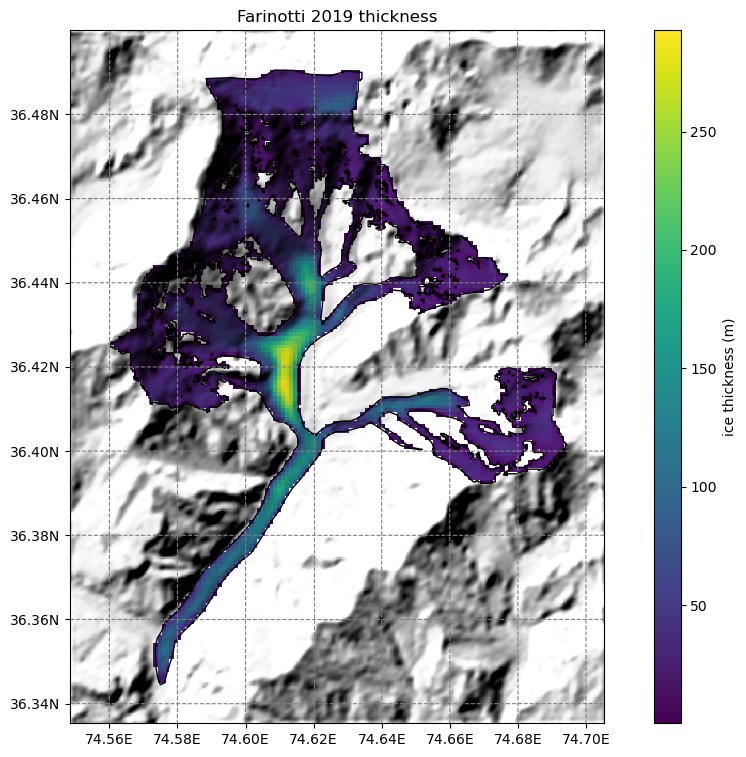

In [18]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))
smap.set_cmap('viridis')
smap.set_data(ds.consensus_ice_thickness)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice thickness (m)')
ax.set_title('Farinotti 2019 thickness');

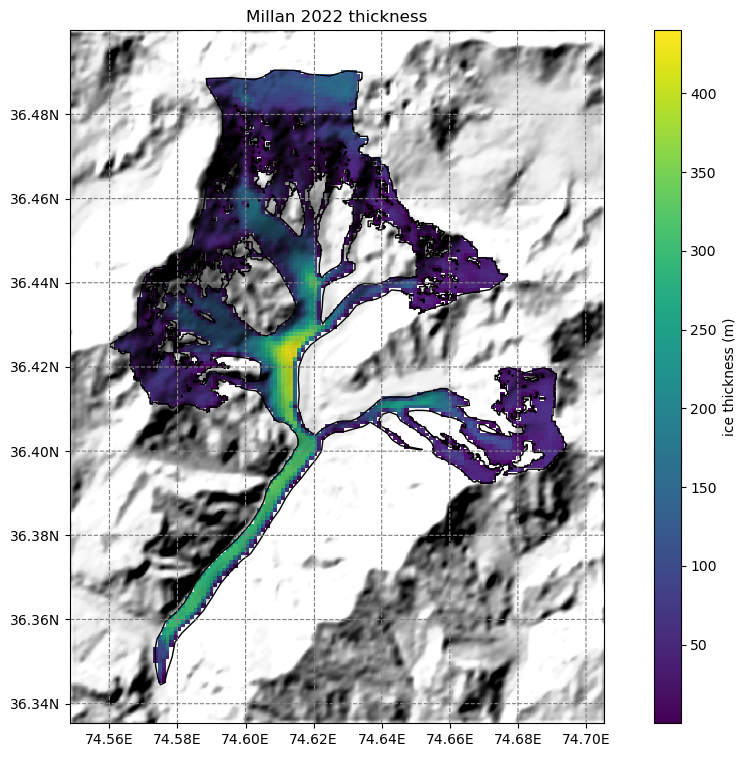

In [19]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))
smap.set_cmap('viridis')
smap.set_data(ds.millan_ice_thickness.where(ds.glacier_mask))
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='ice thickness (m)')
ax.set_title('Millan 2022 thickness');

## Some additional gridded attributes 

Let's also add some attributes that OGGM can compute for us:

In [20]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs)

2023-03-14 09:10:57: oggm.workflow: Execute entity tasks [gridded_attributes] on 1 glaciers
2023-03-14 09:10:58: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 1 glaciers


Let's open the gridded data file again with xarray:

In [21]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset>
Dimensions:                  (x: 134, y: 174)
Coordinates:
  * x                        (x) float32 -6.279e+03 -6.174e+03 ... 7.686e+03
  * y                        (y) float32 4.039e+06 4.039e+06 ... 4.021e+06
Data variables: (12/23)
    topo                     (y, x) float32 6.794e+03 6.829e+03 ... 3.782e+03
    topo_smoothed            (y, x) float32 6.74e+03 6.758e+03 ... 3.79e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    aspect                   (y, x) float32 3.332 3.375 3.478 ... 3.638 3.608
    slope_factor             (y, x) float32 1.186 1.195 1.237 ... 1.823 1.84
    dis_from_border          (y, x) float32 4.79e+03 4.696e+03 ... 7.029e+03
    catchment_area           (y, x) float32 nan nan nan nan ... nan nan nan nan
    lin_mb_above_z           (y, x) float32 nan nan nan nan ... nan nan nan nan
    oggm_mb_above_z          (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=74.619 +k=0.9996 +x_0=0 +y_0=...
    max_h_dem:      7539.0
    min_h_dem:      2409.0
    max_h_glacier:  7445.0
    min_h_glacier:  2476.0

The file contains several new variables with their description. For example:

In [22]:
ds.oggm_mb_above_z

<xarray.DataArray 'oggm_mb_above_z' (y: 174, x: 134)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float32 -6.279e+03 -6.174e+03 ... 7.581e+03 7.686e+03
  * y        (y) float32 4.039e+06 4.039e+06 4.039e+06 ... 4.021e+06 4.021e+06
Attributes:
    units:        kg/year
    long_name:    MB above point from OGGM MB model, without catchments
    description:  Mass balance cumulated above the altitude of thepoint, henc...

Let's plot a few of them (we show how to plot them with xarray and with oggm:

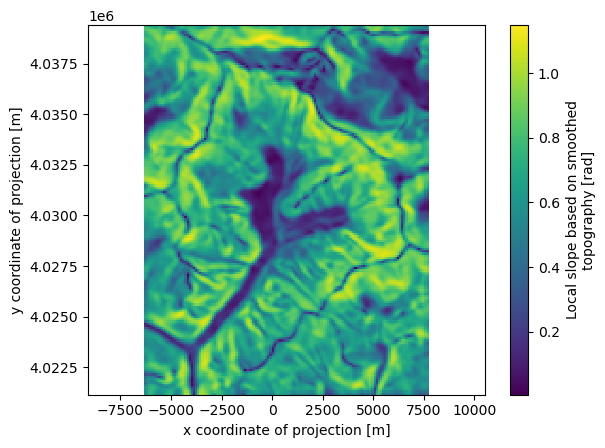

In [23]:
ds.slope.plot();
plt.axis('equal');

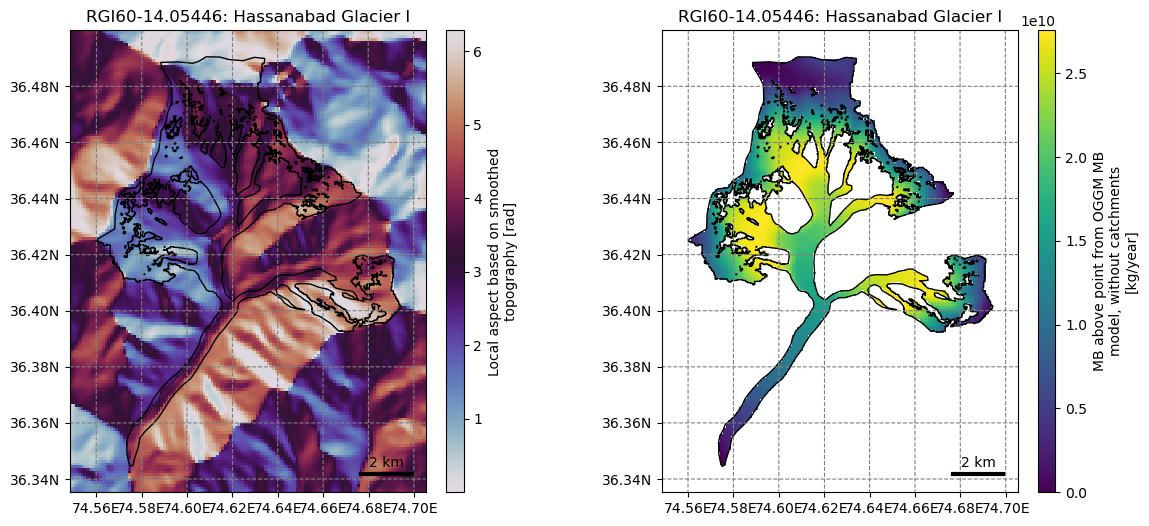

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
graphics.plot_raster(gdir, var_name='aspect', cmap='twilight', ax=ax1)
graphics.plot_raster(gdir, var_name='oggm_mb_above_z', ax=ax2)

<div class="alert alert-info">
    <b>
        In a few lines of code, we have used OGGM to generate or deliver a bunch of data for this glaciers. A similar workflow can be used on ALL of them! With this, we hope to facilitate access to data for many other models or machine learning workflows.
    </b>
</div>